In [389]:
import google_trend_data #importing google trend data collector file
from google_trend_data import search_data_collect as goog

import var_treat as vt

import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt

**Collecting Google Data** by calling the google trend file

In [390]:
#Ontario Search Data
#df_house_index_ON, search_query = goog('house for sale',['CA-ON']).extract_data()

In [391]:
#British Columbia Search Data
#df_house_index_BC, search_query = goog('house for sale',['CA-BC']).extract_data()

In [392]:
#Alberta Search Data
#df_house_index_AB, search_query = goog('house for sale',['CA-AB']).extract_data()

In [393]:
##Storing the data in excel -- Sometimes google trend don't allow you to collect huge amount data at short time. Better safe to store the data in excel
# with pd.ExcelWriter('search_data_AB.xlsx') as writer:  
#     df_house_index_AB[:].to_excel(writer, sheet_name='Sheet_name_1')

**Importing The data from excel**

In [394]:
#Loading the housesearch price data
#df_search_cad = pd.read_excel('search_data.xlsx').set_index('date')
#df_search_on = pd.read_excel('search_data_ON.xlsx').set_index('date')
df_search_ab = pd.read_excel('search_data_AB.xlsx').set_index('date')
# df_search_bc = pd.read_excel('search_data_BC.xlsx').set_index('date')

example

In [395]:
#df_search_cad.head()

**Experimenting with various treatment of the variable**

In [396]:
time_start = 72-20 #date index -- starting from Jan 2010
df_hs_median = vt.Median_decomp(df_search_ab[time_start:]) #Median search data
df_hs_median_season = vt.Deseasonalize_STL(df_hs_median)
df_hs_median_season_smooth = vt.ExpSmoother((df_hs_median_season))

df_hs_median_season_smooth_ma = df_hs_median_season_smooth.rolling(window =20).mean()

df_hs_treat = df_hs_median_season_smooth_ma[20:]

c:\Users\zerocool\Desktop\Canada House price Forecast\var_treat.py:92: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [397]:
df_hs_treat

,index
2010-01-01,99.685469
2010-02-01,99.833258
2010-03-01,99.950251
2010-04-01,100.115065
2010-05-01,100.196254
...,...
2022-04-01,128.814150
2022-05-01,129.127400
2022-06-01,129.339644
2022-07-01,129.588219


In [398]:
df_index_main_visual = df_hs_median
df_index_main_visual['Deseason'] = df_hs_median_season
df_index_main_visual['Smooth'] = df_hs_median_season_smooth


fig_2 = px.line(df_index_main_visual, color='variable',labels={"value": "Level","_index": "","variable": ""}, width=600, height=400,title="Decomposed and Deseasoned")
fig_2.show()

In [399]:
#Loading the actual house price data
filename = 'cad_hp_main.xlsx'

xls=pd.ExcelFile(filename) 
df_hp = pd.read_excel(xls)
df_hp = df_hp.set_index(pd.Index(df_hs_treat.T.columns.values[:150])).iloc[:,1:] #the 150 is June-2022 -- No house price data from stats can for july 


**Preparing the dataframe for analysis**

In [400]:
df_main = df_hs_treat
location = 'ab'

df_main['hp'] = df_hp[location]
df_main['hp_lag'] = df_hp[location]

fig_2 = px.line(df_main, color='variable',labels={"value": "Level","_index": "","variable": ""}, width=600, height=400,title="House Price and Goog Trend Data")
fig_2.show()

C:\Users\zerocool\AppData\Local\Temp/ipykernel_22796/1935064921.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\zerocool\AppData\Local\Temp/ipykernel_22796/1935064921.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [401]:
df_main = df_main.pct_change()

series_lagg = {
    'hp': 4,
    'hp_lag': 5,
}

df_main_clean = vt.KalSmoother(vt.data_prep(df_main,series_lagg))

In [402]:
fig_2 = px.line(df_main_clean, color='variable',labels={"value": "Level","_index": "","variable": ""}, width=800, height=500,title="House Price Lagg 8 Months to Trend Data")
fig_2.show()

In [403]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = df_main_clean[['index','hp_lag']][:].values
Y = df_main_clean[['hp']].values


######Setting the training length
train_size = int(len(X) * 0.30)
train_size

####Splitting the train and test data set
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = Y[0:train_size], Y[train_size:len(X)]


lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)


print(np.round(mean_squared_error(y_test, y_pred)*100, decimals=3),

#R2 is negative only when the chosen model does not follow the trend of the data, so fits worse than a horizontal line.
r2_score(y_test, y_pred))

0.001 0.8009945880416216


[[0.41039216 0.57331725]] [-0.00023163]


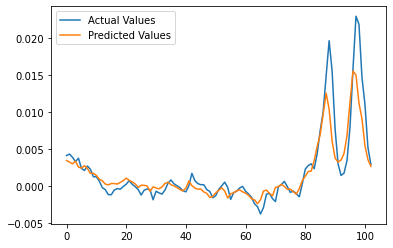

In [404]:
print(lr.coef_, lr.intercept_)

plt.plot(y_test, label="Actual Values")
plt.plot(y_pred, label="Predicted Values")
plt.legend()
plt.show()


In [405]:
import statsmodels.api as sm

log_clf =sm.OLS(y_test,X_test)

classifier = log_clf.fit()

print(classifier.summary2())

                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.866     
Dependent Variable:     y                AIC:                         -987.8434 
Date:                   2022-08-05 22:45 BIC:                         -982.5740 
No. Observations:       103              Log-Likelihood:              495.92    
Df Model:               2                F-statistic:                 333.3     
Df Residuals:           101              Prob (F-statistic):          3.31e-45  
R-squared (uncentered): 0.868            Scale:                       3.9263e-06
--------------------------------------------------------------------------------------
            Coef.        Std.Err.          t          P>|t|        [0.025       0.975]
--------------------------------------------------------------------------------------
x1          0.3504         0.0942        3.7205       0.0003       0.1636       0.5373
x2          0.7954         0.